# BLU05 - Learning Notebook - Part 3 of 3 - Multi-step Forecasting

In [1]:
import utils 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import pandas as pd 
import numpy as np 
import statsmodels.api as sm  # <--- Yay! API! 
%matplotlib inline 
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16, 5)
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)   
warnings.filterwarnings("ignore") # specify to ignore warning messages

In [2]:
airlines = utils.load_airline_data()
airlines_logged = np.log(airlines)

In [3]:
train = airlines_logged[:-24]
test = airlines_logged[-24:]

## 1. Pmdarima

### 1.1 Auto Sarimax

In the last notebook we promised to show you how to get the best parameters for SARIMAX. The time has come!

You may already be suspecting that what happens is that we will train several models in the train set and then compare their AIC (which already penalises for complexity so in theory you don't need a validation set). And you would be right! But instead of doing it manually we will use [pmdarima](http://alkaline-ml.com/pmdarima/), which is a wrapper around statsmodels for SARIMAX models which not only automatises the SARIMAX model selection but also offers some extra functionality we will see later. 

In [4]:
import pmdarima as pm

Let's use the `AutoARIMA` function which will automatically search for the best ARIMA model in the train set. The only thing we will tell `autoARIMA` is that we know the seasonality is of 12 periods, by using `m=12`. We could also ask `autoARIMA` to search for it, but it would be considerably slower.

For more information on how `AutoARIMA` actually works make sure to check the [documentation](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html)

In [5]:
sarimax = pm.AutoARIMA(trace=True, supress_warnings=True, m=12)
sarimax.fit(train)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=-384.183, Time=2.38 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-277.702, Time=0.10 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-381.231, Time=1.56 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-341.622, Time=0.63 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-118.985, Time=0.03 sec
 ARIMA(2,0,2)(0,1,1)[12] intercept   : AIC=-389.778, Time=2.60 sec
 ARIMA(2,0,2)(0,1,0)[12] intercept   : AIC=-365.956, Time=0.78 sec
 ARIMA(2,0,2)(0,1,2)[12] intercept   : AIC=-387.770, Time=4.53 sec
 ARIMA(2,0,2)(1,1,0)[12] intercept   : AIC=-383.807, Time=2.20 sec
 ARIMA(2,0,2)(1,1,2)[12] intercept   : AIC=-385.818, Time=5.39 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=-391.105, Time=1.63 sec
 ARIMA(1,0,2)(0,1,0)[12] intercept   : AIC=-366.343, Time=0.62 sec
 ARIMA(1,0,2)(1,1,1)[12] intercept   : AIC=-385.863, Time=2.07 sec
 ARIMA(1,0,2)(0,1,2)[12] intercept   : AIC=-389.117, Time=4.34 sec
 ARIMA(1,0,2)(1,1,0

AutoARIMA(m=12, trace=True)

Ok! So this is how we got to the hyperparameters `ARIMA(2,0,0)(0,1,1)[12]`. 

A cool thing about 'pmdarima' is that it aims to mimic `sklearn`'s api. So how do you think we can get predictions from our model? Instead of `get_forecast`, we simply use `predict`:

In [6]:
sarimax_forecast = sarimax.predict(24)

Let's also check if the MAE is the same as with statsmodels:

In [7]:
mean_absolute_error(np.exp(sarimax_forecast),np.exp(test))

10.62078098295826

Ok, all good!

As we saw in the last notebook, it's interesting to validate how well our model would perform for several samples by making multiple forecasts. We also saw that we can leave our model static, we can refit or we can completely remake it. Leaving our model static is not trivial in pmdarima as it is on statsmodels. For refitting on pmdarima it's slitghly different from statsmodels, because it has a method which refits the model but using as initial parameters the ones from the old model.

The following loop implements a multiple one-step forecast using the `update` method from `pmdarima`. As mentioned, this is similar to refitting, but it initializes the parameters with the values from the previous fit.

In [8]:
sarimax_forecast_one_step_refit = []
sarimax.fit(train)        # Note that we're fitting the autoArima again. This is to make sure you always 
for i in np.arange(0,24): # run it before the rest of the loop
    next_step_forecast = sarimax.predict(1)[0]
    sarimax_forecast_one_step_refit.append(next_step_forecast)
    sarimax = sarimax.update(test[i:i+1])

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=-384.183, Time=2.14 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-277.702, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-381.231, Time=1.88 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-341.622, Time=0.60 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-118.985, Time=0.02 sec
 ARIMA(2,0,2)(0,1,1)[12] intercept   : AIC=-389.778, Time=2.47 sec
 ARIMA(2,0,2)(0,1,0)[12] intercept   : AIC=-365.956, Time=0.88 sec
 ARIMA(2,0,2)(0,1,2)[12] intercept   : AIC=-387.770, Time=4.44 sec
 ARIMA(2,0,2)(1,1,0)[12] intercept   : AIC=-383.807, Time=2.06 sec
 ARIMA(2,0,2)(1,1,2)[12] intercept   : AIC=-385.818, Time=5.06 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=-391.105, Time=1.62 sec
 ARIMA(1,0,2)(0,1,0)[12] intercept   : AIC=-366.343, Time=0.64 sec
 ARIMA(1,0,2)(1,1,1)[12] intercept   : AIC=-385.863, Time=2.06 sec
 ARIMA(1,0,2)(0,1,2)[12] intercept   : AIC=-389.117, Time=6.53 sec
 ARIMA(1,0,2)(1,1,0

Let's take a look at the MAE:

In [9]:
mean_absolute_error(np.exp(sarimax_forecast_one_step_refit),np.exp(test))

11.084905016114638

You may remember that with statsmodels the one-step forecast reffited model obtained an MAE of 10.9%, but now we got 11.1%. The most probable reason is that initializing the parameters from the previous fit doens't really help in this case. Remember that this is just one case, for another period or another dataset the situation can be the opposite.

As mentioned, instead of refitting we could also completely remake the model. This means that instead of updating the model on our for loop, we would fit a new auto-arima model on each step.

### 1.2 Boxcox Transformation

Remember in the first notebook when we mentioned that the log transformation is just a particular case of the box-cox transofrmation? Well pmdarima makes it easy to automate boxcox to find the best transformation to unskew our distribution. Pmdarima also has pipelines similar to sklearn, making it easy to create a preprocessing and modelling pipeline. This means all the box-cox transformations and inverse transformations are implitcitely calculated :)

In [10]:
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import BoxCoxEndogTransformer

In [11]:
train = airlines[:-24]
test = airlines[-24:]

In [12]:
sarimax_pipeline = Pipeline([
    ('boxcox', BoxCoxEndogTransformer(lmbda2=1e-6)),
    ('arima', pm.AutoARIMA(trace=True,
                           suppress_warnings=True,
                           m=12
                          )
    )
])

sarimax_pipeline.fit(train)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=-287.803, Time=3.34 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-182.354, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-284.619, Time=1.13 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-247.225, Time=1.18 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-21.412, Time=0.02 sec
 ARIMA(2,0,2)(0,1,1)[12] intercept   : AIC=-291.976, Time=2.32 sec
 ARIMA(2,0,2)(0,1,0)[12] intercept   : AIC=-270.150, Time=0.83 sec
 ARIMA(2,0,2)(0,1,2)[12] intercept   : AIC=-289.989, Time=4.83 sec
 ARIMA(2,0,2)(1,1,0)[12] intercept   : AIC=-286.731, Time=2.23 sec
 ARIMA(2,0,2)(1,1,2)[12] intercept   : AIC=-288.173, Time=7.04 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=-293.204, Time=1.02 sec
 ARIMA(1,0,2)(0,1,0)[12] intercept   : AIC=-270.475, Time=0.40 sec
 ARIMA(1,0,2)(1,1,1)[12] intercept   : AIC=-290.856, Time=2.32 sec
 ARIMA(1,0,2)(0,1,2)[12] intercept   : AIC=-291.252, Time=4.29 sec
 ARIMA(1,0,2)(1,1,0)

Pipeline(steps=[('boxcox', BoxCoxEndogTransformer(lmbda2=1e-06)),
                ('arima', AutoARIMA(m=12, suppress_warnings=True, trace=True))])

In [13]:
mean_absolute_error(sarimax_pipeline.predict(24),test)

10.125004757983051

Wow, that's almost a 10% improvement compared to the one with the log transform. Great!

## 2. New Challenge!

You have been learning a lot but I bet you're already tired of looking at the yearly air passengers on every plot. 

Let's test your new skills on a new dataset, and take the opportunity to mature the standard workflow.

In [14]:
df = pd.read_csv('data/pv.csv')
df.Datetime = pd.to_datetime(df.Datetime)
df = df.set_index('Datetime')
df = df.sort_index()
train = df['2016-01']
test = df['2016-02']

First let's take a look at the data

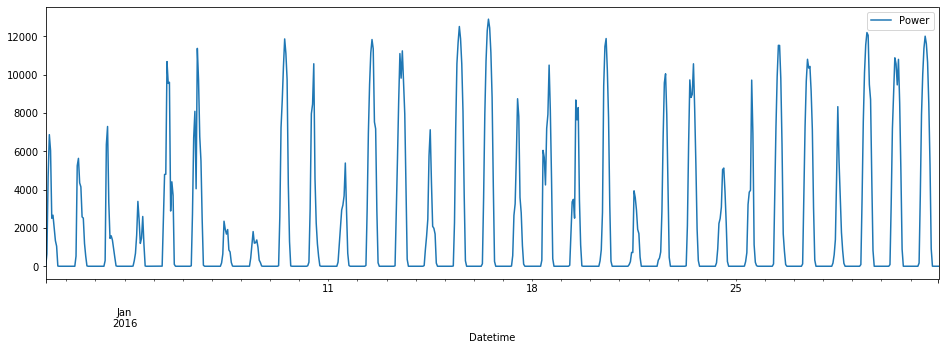

In [15]:
train.plot()

It clearly seems to have some seasonality going on. On the other hand, there doesn't seem to be any significant trend. The variance also changes quite significantly without a clear pattern. Let's check the ACF plot to better understand the patterns going on.

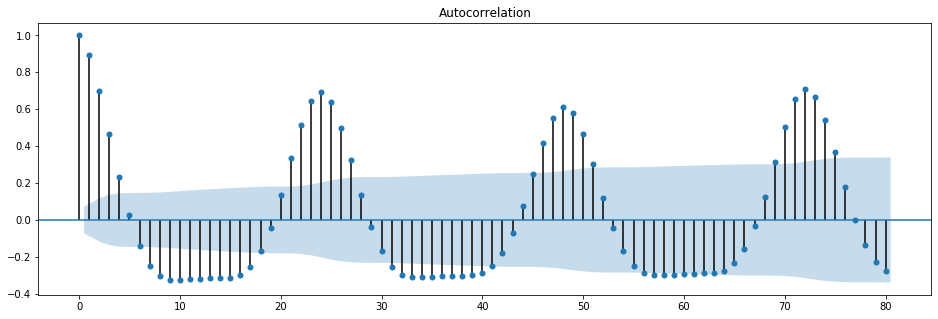

In [16]:
plot_acf(train.dropna(), alpha=.05, lags=80)  
plt.show()

From the ACF plot we can clearly see we have a 24 hours seasonality, which makes sense given the domain knowledge we have of sunlight.

Also note from the time series plot that we have values of 0, this can be problematic when taking the box-cox transform, so let's use `lmbda2=1` which adds a constant of 1 to make the data non-zero when applying the transformation.

In [17]:
sarimax_pipeline = Pipeline([
    ('boxcox', BoxCoxEndogTransformer(lmbda2=1)),
    ('arima', pm.AutoARIMA(trace=True,
                           suppress_warnings=True,
                           m=24, 
                           method='nm', # More data means longer let's use 'nm' to make it faster
                           maxiter=20, # Let's also reduce maxiter to make it faster.
                           
                          )
    )
])

sarimax_pipeline.fit(train)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[24] intercept   : AIC=11857.366, Time=1.13 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=3375.167, Time=0.12 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=0.90 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=2222.179, Time=0.82 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=3794.358, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[24] intercept   : AIC=2691.008, Time=0.10 sec
 ARIMA(0,0,1)(1,0,1)[24] intercept   : AIC=3316.097, Time=0.88 sec
 ARIMA(0,0,1)(0,0,2)[24] intercept   : AIC=2434.210, Time=3.71 sec
 ARIMA(0,0,1)(1,0,0)[24] intercept   : AIC=2804.492, Time=0.75 sec
 ARIMA(0,0,1)(1,0,2)[24] intercept   : AIC=3589.154, Time=3.71 sec
 ARIMA(0,0,0)(0,0,1)[24] intercept   : AIC=2822.229, Time=0.78 sec
 ARIMA(1,0,1)(0,0,1)[24] intercept   : AIC=1728.627, Time=0.82 sec
 ARIMA(1,0,1)(0,0,0)[24] intercept   : AIC=2055.341, Time=0.10 sec
 ARIMA(1,0,1)(1,0,1)[24] intercept   : AIC=2097.269, Time=0.91 sec
 ARIMA(1,0,1)(0,0,2)[24

Pipeline(steps=[('boxcox', BoxCoxEndogTransformer(lmbda2=1)),
                ('arima',
                 AutoARIMA(m=24, maxiter=20, method='nm',
                           suppress_warnings=True, trace=True))])

Let's look at the in-sample predictions:

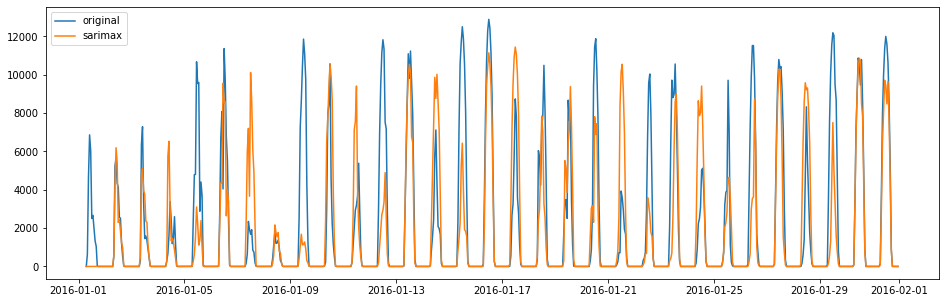

In [18]:
plt.plot(train, label='original')
plt.plot(train.index, sarimax_pipeline.predict_in_sample(), label='sarimax')
plt.legend()

The model seems to have captured the seasonality quite well, but the changing variance not that much. Let's look at a multi-step forecast:

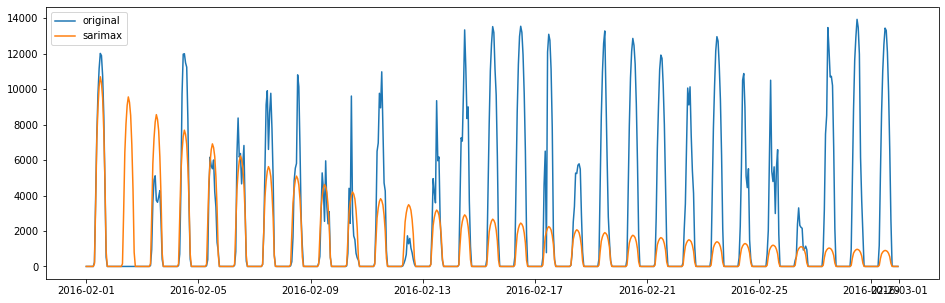

In [19]:
plt.plot(test, label='original')
plt.plot(test.index, sarimax_pipeline.predict(29*24), label='sarimax')
plt.legend()

The model clearly didn't capture any patterns to explain the variance changes throughout the time series. This probably means there's something missing on our model. Indeed it makes sense that there is some temporal relation in solar production, but not all days are equal right? There is something that **causes** some days to produce more power than others. Indeed, some days have more sunlight than others. Let's think a bit about causality and look how we can incorporate that into our model next.

### 2.1 Causality

When talking about modelling in geral we often refer to dependent and indepedent variables, as you have learned. But there is another nomenclature for the relations between different variables which is specially useful in timeseries. This nomenclature is based on the causal relation between the variables. Correlation does not imply causation. If you don't remember why, check this [website](https://www.tylervigen.com/spurious-correlations). Even if you do remember, do yourself a favor and check it. So what is this nomenclature? Basically it splits variables into endogenous or exogeneous, whose differences are detailed below.


#### Endogenous Variable
From [Merriam Webster, 2.a](https://www.merriam-webster.com/dictionary/endogenous) : caused by factors inside the organism or system. In other words, an endogenous variable is a variable whose value is determined by the model you are using to predict a time series. It is like a feedback loop: your model will use values that it produced in previous predictions. It is an input signal that comes from the model that produces that same signal. When you use this type of variables, you are assuming that the next values of a time series will depend on previous values of that same time series.

#### Exogenous Variable
From [Merriam Webster](https://www.merriam-webster.com/dictionary/exogenous), introduced from or produced outside the organism or system; specifically : not synthesized within the organism or system. These are variables/features that aren't predicted by the model you build nor is it affected by predictions your model makes. This type of feature is believed to have an impact on what you want to predict but, no matter what the prediction you make, the exogenous variable won't be affected.

You might be wondering "Aren't those endogenous equal to dependent variables and exogenous equal to independent variables?". The answer is no. Let me give you an example to show you the difference: imagine you have a model that predicts the price of a product based on (1) demand and (2) past price values. You might be tempted to think that (1) is exogenous and (2) is endogenous. But economists know that if you lower the price of a good, people will be more open to acquire more of it. And, as such, the demand is not independent the predictions your model does, even more if you use those predictions to set the price. You can still use the demand as an exogenous variable but you will break the assumption of independence between the prediction and the exogenous variable. If you do that, don't tell us that you weren't warned about it.

Another example: when predicting the stock value for a specific company, the stock values of previous days are the endogenous variables while descriptors like the number of employees, number of products, number of clients are the exogenous variables.

### 2.2 Exogenous Variables in SARIMAX

The exogenous variable we're looking for is the solar radiation. But look that we can't simply use the measured solar radiation at each hour. Imagine you want to predict the solar production for the next month, you don't have the real values of the solar radiation for next month, so you need to use existing forecasts. This is quite common for weather variables, such as solar radiation, wind speed, precipitation, etc.

Then, let's load a radiation forecast dataset. Note that the index of this dataset doesn't correspond to the measure date, it corresponds to the forecasts date. And all these forecasts were made the previous month, so this means we cna use them for next month forecasts.

In [20]:
exog = pd.read_csv('data/radiation.csv')
exog.Datetime = pd.to_datetime(exog.Datetime)
exog = exog.set_index('Datetime')
exog = exog.sort_index()
exog_train = exog['2016-01-01 07':'2016-01-31']
exog_test = exog['2016-02']

In [21]:
sarimax_pipeline_exog = Pipeline([  #The boxcox transform has been removed because it messes with the exogenous input
    ('arima', pm.AutoARIMA(trace=True,
                           suppress_warnings=True,
                           m=24, 
                           method='nm',
                           maxiter=20,
                           
                          )
    )
])

sarimax_pipeline_exog.fit(train,exog_train)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[24] intercept   : AIC=11007.871, Time=1.31 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=11554.604, Time=0.11 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=11008.410, Time=1.13 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=11163.427, Time=0.90 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=11682.096, Time=0.12 sec
 ARIMA(2,0,2)(0,0,1)[24] intercept   : AIC=11005.715, Time=1.24 sec
 ARIMA(2,0,2)(0,0,0)[24] intercept   : AIC=11017.336, Time=0.16 sec
 ARIMA(2,0,2)(0,0,2)[24] intercept   : AIC=11009.762, Time=4.87 sec
 ARIMA(2,0,2)(1,0,0)[24] intercept   : AIC=11004.824, Time=1.45 sec
 ARIMA(2,0,2)(2,0,0)[24] intercept   : AIC=11013.516, Time=6.69 sec
 ARIMA(2,0,2)(2,0,1)[24] intercept   : AIC=11013.318, Time=4.65 sec
 ARIMA(1,0,2)(1,0,0)[24] intercept   : AIC=11003.543, Time=1.30 sec
 ARIMA(1,0,2)(0,0,0)[24] intercept   : AIC=11016.060, Time=0.15 sec
 ARIMA(1,0,2)(2,0,0)[24] intercept   : AIC=11012.659, Time=5.05 sec
 ARIM

Pipeline(steps=[('arima',
                 AutoARIMA(m=24, maxiter=20, method='nm',
                           suppress_warnings=True, trace=True))])

Let's look at the in-sample predictions:

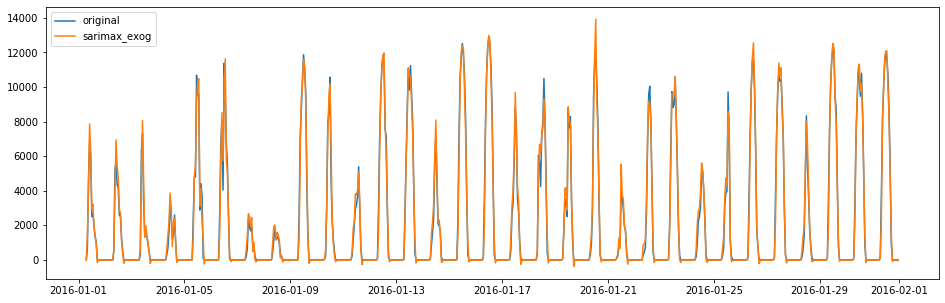

In [22]:
plt.plot(train, label='original')
plt.plot(train.index, sarimax_pipeline_exog.predict_in_sample(exog_train), label='sarimax_exog')
plt.legend()

It captured the variance changes much better! What about the multi-step forecast?

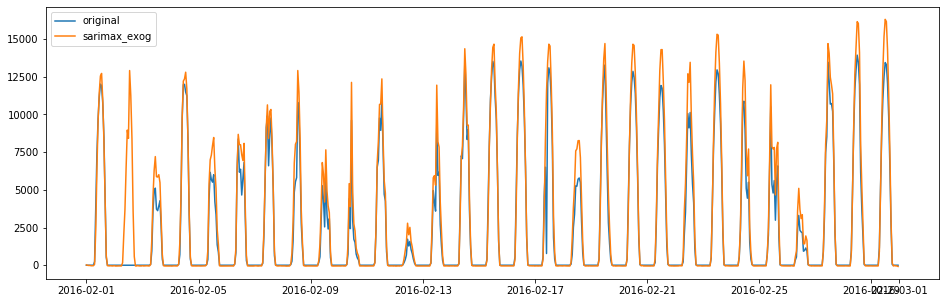

In [23]:
plt.plot(test, label='original')
plt.plot(test.index, sarimax_pipeline_exog.predict(29*24,exog_test), label='sarimax_exog')
plt.legend()

Looking good! This is a problem where using exogenos variables clearly improves performance. But there are many other cases you can imagine. For example, to forecast supermarket sales it might relevant to take into acount temperature forecasts, to forecast wind power we need to take into account wind forecasts, etc.

## 3. Confidence Intervals

Also, have we told you that you can also get confidence intervals for free? Simply use `return_conf_int=True`:

In [24]:
preds = sarimax_pipeline_exog.predict(24*7,exog_test[:24*7], return_conf_int=True)

In [25]:
def plot_predictions(series_, pred_):
    
    """ 
    Remember Sam told us to build functions as we go? Let's not write this stuff again. 
    """
    
    mean_predictions_ = pd.Series(pred_[0], index=series_.index)

    pred_ci_ = pd.DataFrame(pred_[1], columns=['lower passengers_thousands', 'upper passengers_thousands'],
                           index=series_.index)
    
    series_.plot(label='observed')
    mean_predictions_.plot(label='predicted', 
                           alpha=.7)

    plt.fill_between(pred_ci_.index,
                     pred_ci_['lower passengers_thousands'],
                     pred_ci_['upper passengers_thousands'], 
                     color='k', 
                     alpha=.2)

    plt.legend()
    plt.show()

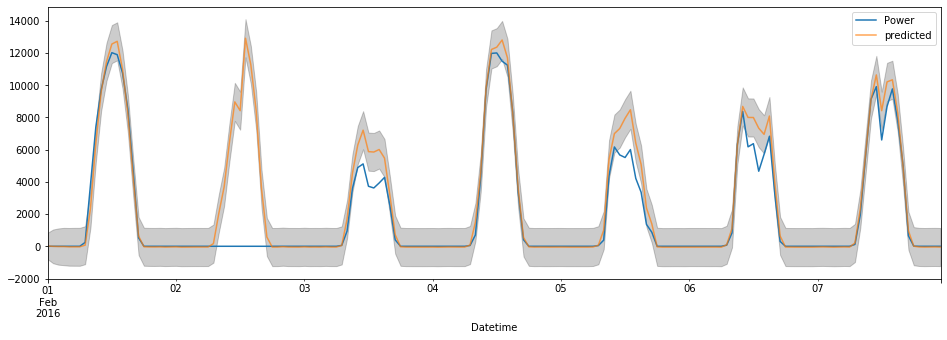

In [26]:
plot_predictions(test['2016-02-01':'2016-02-07'], preds)

Confidence intervals can be very useful for business-driven decisions, in most real scenarios we're not only interested in the mean but also in the uncertainty in our predictions.

Note that we've been talking mostly about time series forecasting, but there are many machine learning applications related with time series, namely time series classification, anomaly detection, change point detection, etc. 

Confidence intervals are particularly important for anomaly detection, you can imagine that when we have real values that fall considerably out of our forecast bounds then we may have some abnormal behavior. For a quick intro to some of the concepts in time series anomaly detection check out this [article](https://docs.microsoft.com/en-us/azure/machine-learning/studio-module-reference/time-series-anomaly-detection).

Also, here we looked quite a lot into SARIMAX models, but there several other time series models and tools. One that deserves special mention is facebook's [Prophet](https://facebook.github.io/prophet/).